### Running graphs

In [1]:
%run -i harm_script.py

In [2]:
rg("gdump")

In [3]:
rd("dump000")

In [4]:
print(t)


0.0


Text(0, 0.5, 'rho')

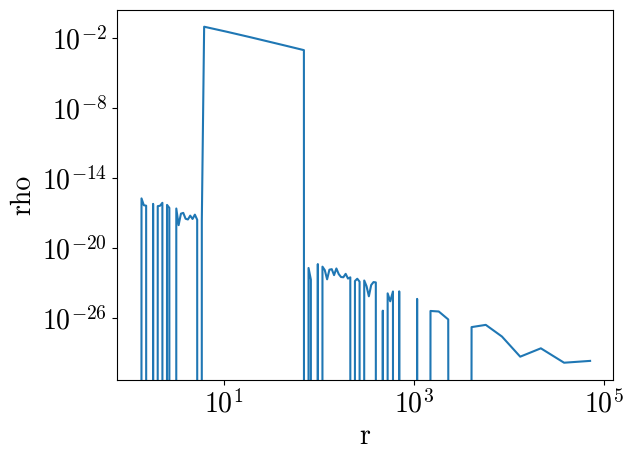

In [5]:
plt.loglog(r[:,ny//2,0], uu[3][:,ny//2,0])
plt.xlabel("r")
plt.ylabel("rho")

(<matplotlib.contour.QuadContourSet at 0x127f13f10>,
 <matplotlib.colorbar.Colorbar at 0x16dc054d0>)

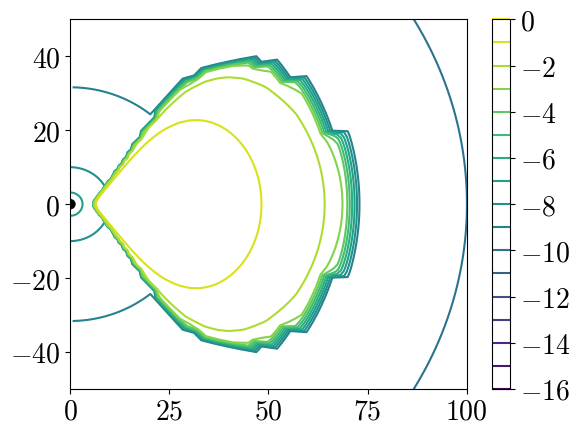

In [6]:
plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True)

(<matplotlib.contour.QuadContourSet at 0x16dcf5510>,
 <matplotlib.colorbar.Colorbar at 0x16dcf52d0>)

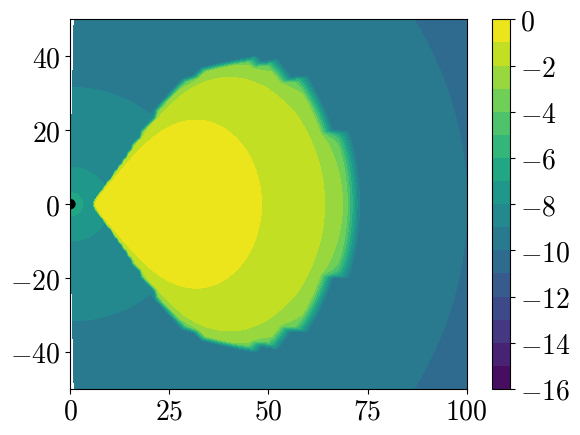

In [7]:
plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled = 1)

(<matplotlib.contour.QuadContourSet at 0x16dfc7c50>,
 <matplotlib.colorbar.Colorbar at 0x16df752d0>)

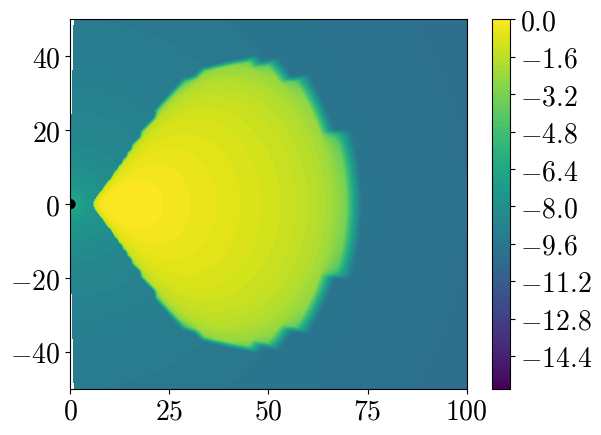

In [8]:
plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled = 1, nc = 100)

In [ ]:
for i in np.arange(155):
    print(i)
    rd("dump%03d" % i)
    plco(np.log10(rho),xy=1,xmax=100,ymax=50,cb=True, isfilled = 1, nc=100)
    plt.savefig("frame%03d.png" % i, dpi = 300)
    

In [ ]:
# ffmpeg -fflags +genpts -r 10 -pattern_type glob -i "frame*.png" -vcodec mpeg4 -qmax 5 movie.mp4

(<matplotlib.contour.QuadContourSet at 0x147e5e510>,
 <matplotlib.colorbar.Colorbar at 0x147d7b3d0>)

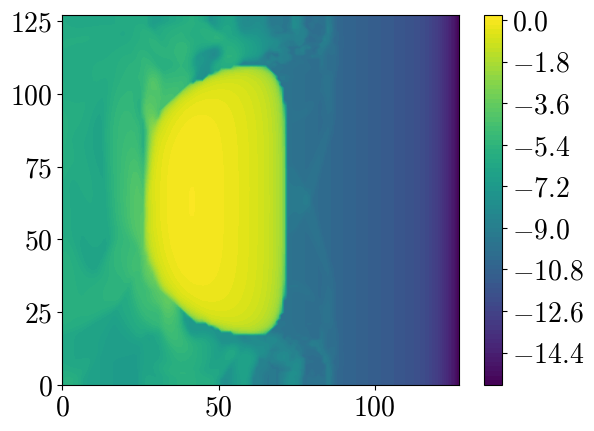

In [10]:
plco(np.log10(rho),xy=0,cb=True,isfilled=1,nc=100) #x = logr, y = theta

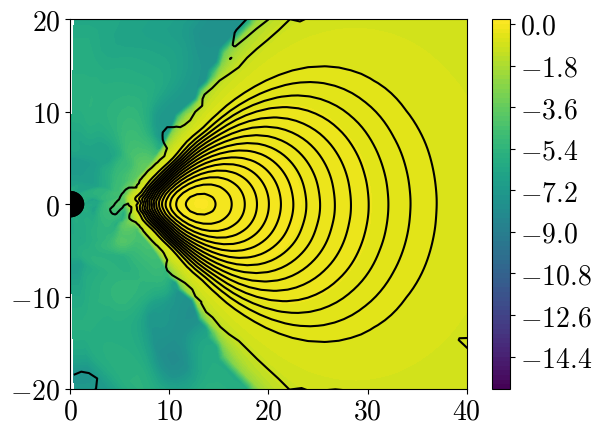

In [14]:
plco(np.log10(rho),xy=1,cb=True,isfilled=1,nc=100)
psi = psicalc()
plc(psi,xy=1,xmax = 40, ymax = 20, colors="black")

### Import

In [1]:
# list the number of dumps
import os
import re
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

%run -i harm_script.py

### Helper funcitons

In [2]:
def make_data_tensor(directory):
    dump_list = []
    for filename in os.listdir(directory):
        if re.match(r'^dump\d+$', filename):
            dump_list.append(filename)
    dump_list.sort()
    
    data = []
    for dump in dump_list:    
        rd(dump)
        # time_tensor = torch.tensor(t)
        rho_tensor = torch.tensor(rho).squeeze(2).unsqueeze(0)
        ug_tensor = torch.tensor(ug).squeeze(2).unsqueeze(0)
        uu_tensor = torch.tensor(uu[1:4]).squeeze(3)
        B_tensor = torch.tensor(B[1:4]).squeeze(3)
        final_tensor = torch.cat((rho_tensor, ug_tensor, uu_tensor, B_tensor), dim= 0)
        # print(final_tensor.shape)
        data.append(final_tensor.unsqueeze(0))

    return data, dump_list
data, dump_list = make_data_tensor("dumps")
torch_data = torch.cat(data, dim=0)
print(torch_data.shape)

torch.Size([155, 8, 128, 128])


In [3]:
BATCH_SIZE = 8

class BHDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset) - 1
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.dataset[idx + 1]
        return data, label
    
loaded_data = BHDataset(torch_data)
train_size = int(0.7 * len(loaded_data))
val_size = int(0.15 * len(loaded_data))
test_size = len(loaded_data) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(loaded_data, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
len(train_dataset)

107

### Neural network architectures

In [5]:
class FFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        return x

In [6]:
fnn = FFNN(input_dim=8 * 128 * 128)
summary(fnn, input_size=(8, 8 * 128 * 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 8, 64]       8,388,672
              ReLU-2                [-1, 8, 64]               0
            Linear-3                [-1, 8, 64]           4,160
              ReLU-4                [-1, 8, 64]               0
            Linear-5            [-1, 8, 131072]       8,519,680
              ReLU-6            [-1, 8, 131072]               0
Total params: 16,912,512
Trainable params: 16,912,512
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.00
Forward/backward pass size (MB): 16.02
Params size (MB): 64.52
Estimated Total Size (MB): 84.53
----------------------------------------------------------------


In [7]:
# Finding the next kerner shape
shape = 128
kernel = 3
stride = 1
((shape - kernel)/ stride) + 1

126.0

In [29]:
class CNN(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=2, stride=2),
            nn.ReLU(),
        )

        self.bottleneck = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1028),
            nn.ReLU(),
            nn.Linear(1028, 1028),
            nn.ReLU(),
            nn.Linear(1028, 128 * 32 * 32),
            nn.Unflatten(1, (128, 32, 32))
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 8, kernel_size=1, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

In [30]:
cnn = CNN(input_channels=8)
summary(cnn, input_size=(8, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           2,336
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]          16,512
              ReLU-4          [-1, 128, 32, 32]               0
           Flatten-5               [-1, 131072]               0
            Linear-6                 [-1, 1028]     134,743,044
              ReLU-7                 [-1, 1028]               0
            Linear-8                 [-1, 1028]       1,057,812
              ReLU-9                 [-1, 1028]               0
           Linear-10               [-1, 131072]     134,873,088
        Unflatten-11          [-1, 128, 32, 32]               0
  ConvTranspose2d-12           [-1, 64, 65, 65]          73,792
             ReLU-13           [-1, 64, 65, 65]               0
  ConvTranspose2d-14          [-1, 8, 1

### Model Training

Loss value: 0.02597637102007866
Loss value: 0.0766686424612999
Loss value: 0.03847318887710571
Loss value: 0.027253659442067146
Loss value: 0.02830640971660614
Loss value: 0.026672404259443283
Loss value: 0.026821328327059746
Loss value: 0.04137684404850006
Loss value: 0.023982807993888855
Loss value: 0.07917602360248566
Loss value: 0.027760736644268036
Loss value: 0.025543594732880592
Loss value: 0.028433751314878464
Loss value: 0.02547064982354641
Loss value: 0.07652325928211212
Loss value: 0.024151107296347618
Loss value: 0.024582253769040108
Loss value: 0.02450387179851532
Loss value: 0.02276119962334633
Loss value: 0.02535286545753479
Loss value: 0.027772536501288414
Loss value: 0.04070185869932175
Loss value: 0.024734456092119217
Loss value: 0.02277873083949089
Loss value: 0.02457781881093979
Loss value: 0.031945645809173584
Loss value: 0.023985909298062325
Loss value: 0.024093300104141235


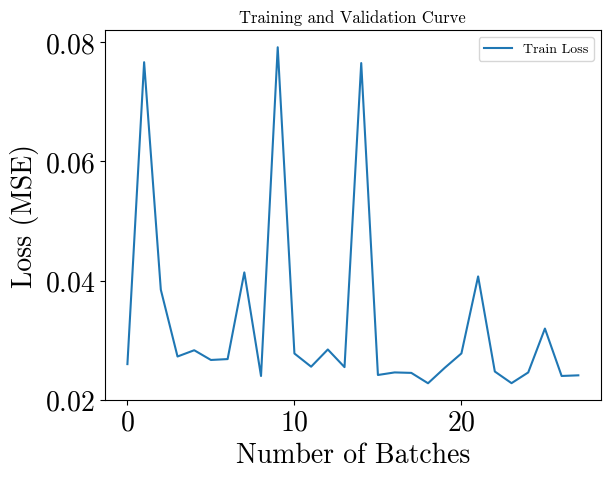

In [11]:
ffn = FFNN(input_dim = 8*128*128)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(params=ffn.parameters())

losses = []
epochs = 2
for epoch in range(epochs):
    for batch_num, (batch, label) in enumerate(train_loader):
        # zero gradients
        optim.zero_grad()
        batch_len = len(batch)

        batch_reshaped = torch.reshape(batch, (batch_len, 8*128*128))

        # make prediction
        pred = ffn.forward(batch_reshaped)
        pred_reshaped = torch.reshape(pred, (batch_len, 8, 128, 128))

        # compute loss
        loss_value = loss_fn(pred_reshaped, label)
        losses.append(loss_value)

        loss_value.backward()
        optim.step()

        print(f"Loss value: {loss_value}")

plt.plot([i for i in range(len(losses))], [loss.item() for loss in losses], label='Train Loss')
plt.title(f'Training and Validation Curve')
plt.xlabel(f'Number of Batches')
plt.ylabel(f'Loss (MSE)')
plt.legend()
plt.show()

Loss value: 0.05341745913028717
Loss value: 0.11323048174381256
Loss value: 0.05032677575945854
Loss value: 0.04575440287590027
Loss value: 0.04615471512079239
Loss value: 0.041027091443538666
Loss value: 0.04456421732902527
Loss value: 0.04596775770187378
Loss value: 0.03945111855864525
Loss value: 0.05366024002432823
Loss value: 0.044324684888124466
Loss value: 0.038471072912216187
Loss value: 0.03753988444805145
Loss value: 0.03578966110944748
Loss value: 0.03766064718365669
Loss value: 0.05353779345750809
Loss value: 0.044739145785570145
Loss value: 0.03712178394198418
Loss value: 0.03696566820144653
Loss value: 0.08503251522779465
Loss value: 0.038771454244852066
Loss value: 0.03636191785335541
Loss value: 0.035753246396780014
Loss value: 0.036608077585697174
Loss value: 0.0354352667927742
Loss value: 0.038237858563661575
Loss value: 0.03510875254869461
Loss value: 0.03424910828471184


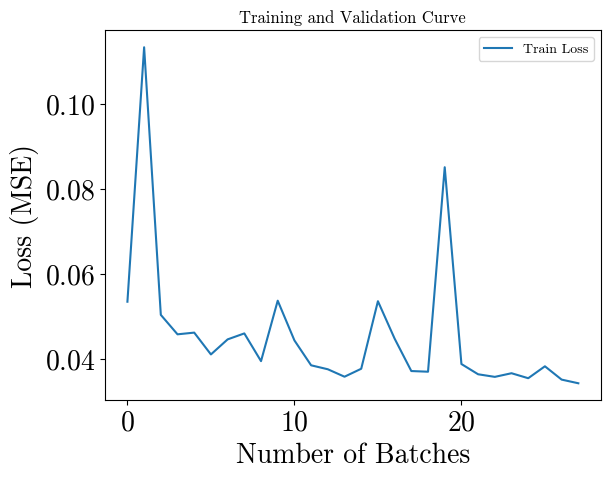

In [31]:
cnn = CNN(input_channels=8)
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(params=cnn.parameters())

losses = []
epochs = 2
for epoch in range(epochs):
    for batch_num, (batch, label) in enumerate(train_loader):
        # zero gradients
        optim.zero_grad()
        batch_len = len(batch)

        # make prediction
        pred = cnn.forward(batch)

        # compute loss
        loss_value = loss_fn(pred, label)
        losses.append(loss_value)

        loss_value.backward()
        optim.step()

        print(f"Loss value: {loss_value}")
plt.plot([i for i in range(len(losses))], [loss.item() for loss in losses], label='Train Loss')
plt.title(f'Training and Validation Curve')
plt.xlabel(f'Number of Batches')
plt.ylabel(f'Loss (MSE)')
plt.legend()
plt.show()

### Play movie

In [13]:
# run FFNN from starting state for length of dumps
ffn.eval()
# get first datapoint
frame = torch_data[0].unsqueeze(0)
preds = []
batch_len = 1
# run mov
for frame_num in range(len(dump_list)):
    preds.append(frame)
    frame_reshaped = torch.reshape(frame, (batch_len,8*128*128))
    raw_frame = ffn.forward(frame_reshaped)
    frame = torch.reshape(raw_frame, (batch_len,8,128,128))


/Users/arjunprasaath/Projects/MSAI/SPRING25-MSAI 490 Practicum/BH_projct/harmpi/anim.py:45: RuntimeWarning: divide by zero encountered in log10
  pred = np.log10(pred)


Saved animated dumps at ./films/movie_ffn.gif


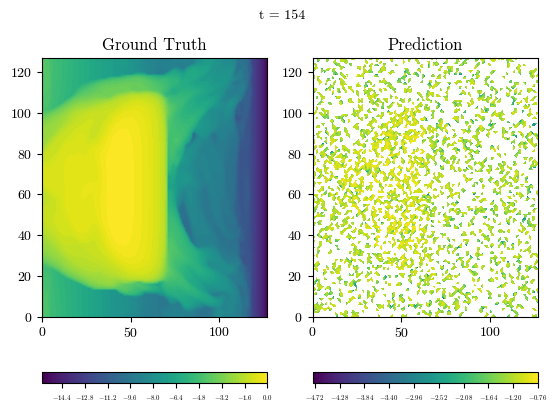

In [23]:
from anim import animate_dumps

animate_dumps(
    dumps = dump_list, 
    preds = preds, 
    save_path = './films/movie_ffn.gif',
    r=r,
    h=h
)


In [26]:
# run FFNN from starting state for length of dumps
cnn.eval()
# get first datapoint
frame = torch_data[0].unsqueeze(0)
preds = []
batch_len = 1
# run mov
for frame_num in range(len(dump_list)):
    preds.append(frame)
    raw_frame = cnn.forward(frame)
    frame = raw_frame

torch.Size([1, 8, 128, 128])


/Users/arjunprasaath/Projects/MSAI/SPRING25-MSAI 490 Practicum/BH_projct/harmpi/anim.py:45: RuntimeWarning: invalid value encountered in log10
  pred = np.log10(pred)


Saved animated dumps at ./films/movie_cnn.gif


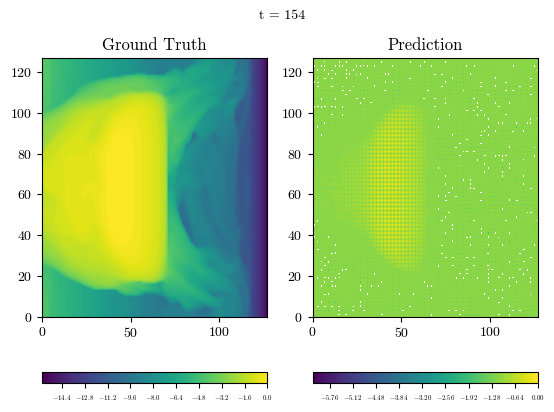

In [27]:
from anim import animate_dumps

animate_dumps(
    dumps = dump_list, 
    preds = preds, 
    save_path = './films/movie_cnn.gif',
    r=r,
    h=h
)


### Miscellaneous

In [11]:
rd("dump153")

Text(0, 0.5, 'rho')

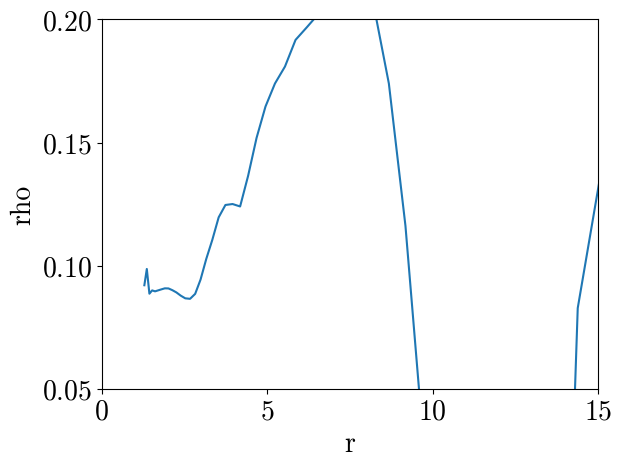

In [15]:
plt.plot(r[:,ny//2,0], -(gdet*rho*uu[1]*_dx2*_dx3).sum(-1).sum(-1))
plt.xlim(0, 15)
plt.ylim(0.05, 0.2)
plt.xlabel("r")
plt.ylabel("rho")

In [ ]:
mpirun -n 4 ./harm 2 2 1

a run with 256^2 cells
USEMPI = 1 in makefile
Perlmutter